In [1]:
import copy
import numpy as np

In [2]:
import matplotlib.gridspec as gridspec

import palettable

In [3]:
import stained_glass.idealized as idealized
import stained_glass.stats as stats

## Make Explanatory Plot

## Parameters

In [4]:
# Number of sightlines
n = 100
r_clump = 0.2
edges_log = np.logspace( -2., np.log10( 20. ), 16 )
edges = np.linspace( 0., 20., 16 )

In [5]:
# Choose statistics
statistics = {
    'TPCF LS': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
    },
    'TPCF simple': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
    },
    'TPCF LS-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
        'radial': True,
    },
    'TPCF simple-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
        'radial': True,
    },
}

#### Setup idealized projections

In [6]:
ips = []

In [7]:
# Radial distribution
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [8]:
# Radial distribution and satellite
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 5,
)
ip.add_ellipse(
    c = (6., 6.),
    a = 1.5,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [9]:
# Clumps
ip = idealized.IdealizedProjection()
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 5.,
    fcov = 0.5,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
        dr = 0.3,
    )

ips.append( ip )

In [10]:
# Filament
ip = idealized.IdealizedProjection()
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-10., 2.),
    theta_a = 20.,
    theta_b = 60.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [11]:
# All of the above
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 4,
)
ip.add_ellipse(
    c = (6., 6.),
    a = 2.,
    value = 4,
)
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 5.,
    fcov = 0.5,
    value = 4,
)
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-10., 2.),
    theta_a = 20.,
    theta_b = 60.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

## Plot of Different Ways of Calculating the Same Statistic

In [12]:
ncols = len( ips )
nrows = 2

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


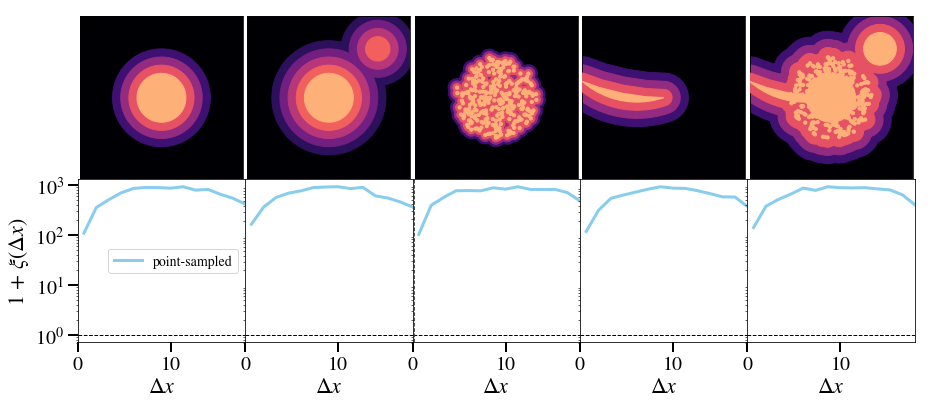

In [21]:
fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    ip.add_background( 0 )
    
    # Generate sightlines
    ip.generate_sightlines( n )
    
    # Plot the idealized image
    ax = plt.subplot( gs[0,i], )
    ip.plot_idealized_projection(
        ax,
    )
    
    # Statistics plot
    ax = plt.subplot( gs[1,i], )
    
    # Get sightlines for statistics
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    vs = ip.evaluate_sightlines()
        
    # Calculate statistic
    tpcf, edges = stats.weighted_tpcf(
        coords,
        vs,
        edges,
    )
    
    # Plot result
    xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )
    ax.plot(
        xs,
        1. + tpcf,
        linewidth = 3,
        color = palettable.cartocolors.qualitative.Safe_2.mpl_colors[0],
        label = 'point-sampled'
    )
#     ax.plot(
#         xs,
#         1. + pair_tpcfs[i],
#         linewidth = 3,
#         color = palettable.cartocolors.qualitative.Safe_2.mpl_colors[1],
#         label = 'pair-sampled'
#     )

    ax.axhline(
        1.,
        linewidth = 1.,
        color = 'k',
        linestyle = '--',
    )

    if i == 2:
        ax.axvline(
            r_clump,
            linewidth = 1.,
            color = '.3',
            linestyle = '--',
        )
        
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if j < 1:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
        # Statistics options
        if j >= 1:
            
            # Remove tick labels
            if not ax.is_first_col():
                ax.tick_params( labelleft=False, left=False, )
            if not ax.is_last_row():
                ax.tick_params( labelbottom=False, bottom=False )
            
            # Limits for statistics
            ax.set_xlim( edges[0], edges[-1]*0.9 )
#             ax.set_ylim( 0.05, 200 )
            
#             ax.set_xscale( 'log' )
            ax.set_yscale( 'log' )
            
            ax.set_xlabel( r'$\Delta x$', fontsize=22 )
            if ax.is_first_col():
                ax.set_ylabel( r'1 + $\xi(\Delta x)$', fontsize=22 )
                
            if ax.is_first_col():
                ax.legend( prop={'size': 14})